# Introduction
This notebook compares the Baseline and Long-Short Term Memory (LSTM) time-series models performance to predict total daily energy demand in Saskatchewan. The choosen Baseline model is Linear Regression. 
Each model is trained and validated using a train-test split and cross-validation for Baseline and LSTm model respectively. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and potential improvements for future work are considered.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [2]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for modules
from tensorflow import keras
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, Objective

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit,  RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from kerastuner.engine.hyperparameters import HyperParameters

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for Cross-validation evaluation and the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a training set and a testing set. The model is trained on the training set and then tested on the testing set to evaluate its performance.

- 
Cross-Validation: Cross-validation is a technique used to evaluate the performance of a machine learning model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds

In [4]:
# Split the data into learning set from 2013-11-01 to 2022-04-31, and using 2022-05-01 to 2023-10-31 as testing set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01'] # train/validation set
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01'] # testing set

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Model Building


## 1. Baseline Model
In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones. In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

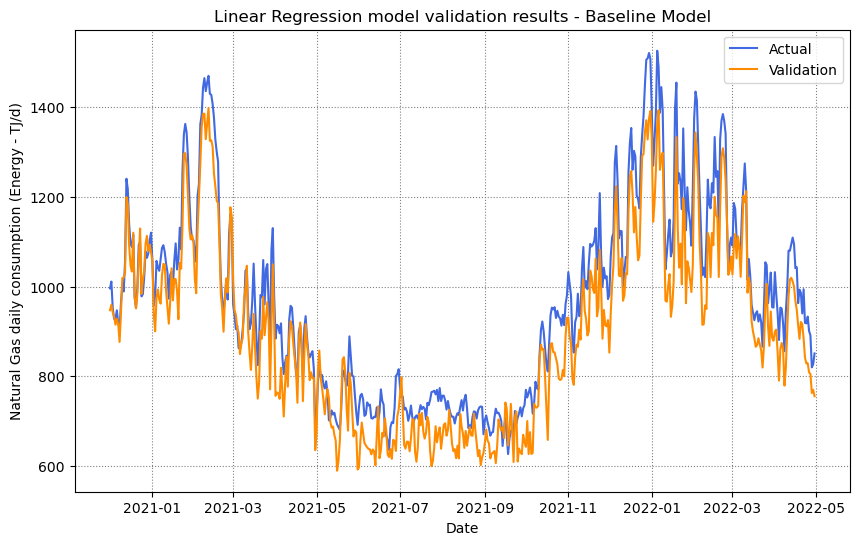

Mean Squared Error: 6656.06
Mean Absolute Error: 70.18
Root Mean Squared Error: 81.58
R-squared: 0.85
Mean Absolute Percentage Error: 7.33%
Median Absolute Percentage Error: 7.05%


In [6]:
# Split the learning dataset to training and validation sets
learning_df = learning_data_df.copy()
training_df = learning_df[learning_df['DATE'] < '2020-12-01']
validation_df = learning_df[learning_df['DATE'] >= '2020-12-01']

# Function to calculate MAPE and MdAPE
def calculate_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return mape, mdape

# Use the train_df for training
X_train = training_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_train = training_df['NG_DEMAND']

# Use the validation_df for testing
X_validate = validation_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_validate = validation_df['NG_DEMAND']

# Create a Linear Regression object
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions on the test set
predictions = lr.predict(X_validate)

# Calculate the mean squared error of the predictions
mse_bm = mean_squared_error(y_validate, predictions)
mae_bm = mean_absolute_error(y_validate, predictions)
rmse_bm = np.sqrt(mse_bm)
r2_bm = r2_score(y_validate, predictions)
mape_bm, mdape_bm = calculate_percentage_error(y_validate, predictions)

# Convert the Date to datetime
validation_df['DATE'] = pd.to_datetime(validation_df['DATE'])

# Plot actual vs. forecast values
plt.figure(figsize=(10, 6))
plt.plot(validation_df['DATE'], y_validate, label='Actual', color='royalblue')
plt.plot(validation_df['DATE'], predictions, label='Validation', color='darkorange')
plt.title('Linear Regression model validation results - Baseline Model')
plt.xlabel('Date')
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)')
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

print(f'Mean Squared Error: {mse_bm:.2f}')
print(f'Mean Absolute Error: {mae_bm:.2f}')
print(f'Root Mean Squared Error: {rmse_bm:.2f}')
print(f'R-squared: {r2_bm:.2f}')
print(f'Mean Absolute Percentage Error: {mape_bm:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_bm:.2f}%')



## 2. Long Short-Term Memory (LSTM) Model
LSTMs are a type of Recurrent Neural Network (RNN) designed to handle time series data by allowing information to persist over multiple time steps.
 Long Short-Term Memory (LSTM) is a special kind of Recurrent Neural Network (RNN) that is capable of learning long-term dependencies. It was introduced to combat the vanishing gradient problem associated with traditional RNNs¹². The key component of LSTM is its memory cell which is controlled by three types of gates⁴:

1. **Forget Gate (f)**: This gate decides how much of the previous state needs to be preserved (or in other words, how much of the state should be forgotten). An activation output of 1.0 means "remember everything" and an activation output of 0.0 means "forget everything"².

2. **Input Gate (i)**: This gate decides which new information is going to enter the state of LSTM. The output of the input gate (a fraction between 0 and 1) is multiplied with the output of the tanh block that produces the new values that must be added to the previous state².

3. **Output Gate**: This gate controls the output stream of information from the memory cell to other LSTM blocks³.

In addition to these, there is also an **Input Modulation Gate (g)** which is often considered as a sub-part of the input gate. It is used to modulate the information that the Input gate will write onto the Internal State Cell by adding non-linearity to the information and making the information Zero-mean².

These gates together allow the LSTM to selectively remember or forget things, which makes it particularly effective for tasks involving sequence prediction, time series analysis, natural language processing, and more¹².

Source: Conversation with Bing, 2024-01-20
(1) LSTMs Explained: A Complete, Technically Accurate, Conceptual ... - Medium. https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2.
(2) Long Short Term Memory Networks Explanation - GeeksforGeeks. https://www.geeksforgeeks.org/long-short-term-memory-networks-explanation/.
(3) Deep Learning | Introduction to Long Short Term Memory. https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/.
(4) What is LSTM and Explain different types of gates used in LSTM?. https://www.i2tutorials.com/what-is-lstm-and-explain-different-types-of-gates-used-in-lstm/.
(5) What is LSTM? Introduction to Long Short-Term Memory - Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/.
(6) undefined. https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/.

### 2.1 Cross-Validation
The TimeSeriesSplit cross-validation method splits the data into multiple training and testing sets based on a specific time point. For example, the data can be split into training sets from the beginning until a certain date and testing sets from that date onwards. 
Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the mode

The goal of cross-validation is to assess the predictive performance of the machine learning model and to judge how it performs outside the sample to a new data set also known as test data. The motivation to use cross-validation techniques is that when we fit a model, we are fitting it to a training dataset. Without cross-validation, we only have information on how does our model perform to our in-sample data. Ideally, we would like to see how does the model perform when we have a new data in terms of accuracy of its predictions. In science, theories are judged by its predictive accuracies. 

This method of data split is implemented on the learning dataset, which split the data into training and validation sets to evaluate the performance of LSTM model. 
- The number of folds is set to 4, meaning the time series data is split into four consecutive segments for cross-validation.
- In each foldof the cross-validation, the learning data is divided into two parts: a training set and a validation set.
- The training set contains past observations, and the validation set contains future observations. This mimics a real-world scenario where the model is trained on historical data and tested on more recent data.
- One key characteristics of time series cross-validation is that the data is split sequentially. Each fold uses a different portion of the time series data for validation, with the training set always preceding the validation set. This ensures that the model is evaluated on unseen data that comes after the training data.d.

#### 2.1.1. Single Layer LSTM model
This LSTM model is define with 64 units, a 'relu' activation function, and a dropout layer to prevent overfitting. The model is compiled with the 'adam' optimizer and 'mean_squared_error' loss function. A function is also defined to calculate various performance metrics including MSE, MAE, RMSE, MAPE, MdAPE, and R-squared. The model is then trained and evaluated using time series cross-validation. For each fold of the cross-validation, the model is trained on the training set, evaluated on the validation set, and the performance metrics are calculated.

20/20 [==============================] - 1s 3ms/step
Fold Metrics - MSE: 4278.478, MAE: 53.620, RMSE: 65.410, MAPE: 7.272%, MdAPE: 7.056%, R-squared: 0.888
20/20 [==============================] - 0s 7ms/step
Fold Metrics - MSE: 2345.060, MAE: 34.071, RMSE: 48.426, MAPE: 4.153%, MdAPE: 3.229%, R-squared: 0.951
20/20 [==============================] - 0s 3ms/step
Fold Metrics - MSE: 2571.069, MAE: 38.047, RMSE: 50.706, MAPE: 4.337%, MdAPE: 3.295%, R-squared: 0.948
20/20 [==============================] - 0s 3ms/step
Fold Metrics - MSE: 2937.268, MAE: 39.876, RMSE: 54.197, MAPE: 4.151%, MdAPE: 3.206%, R-squared: 0.932


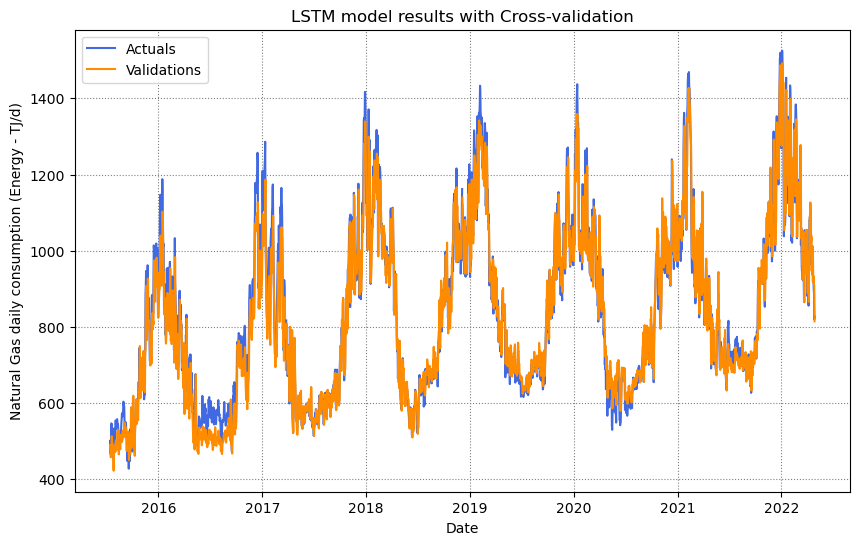


Average Validation Metrics across Folds:
Mean Squared Error: 3032.969%
Mean Absolute Error: 41.403
Root Mean Squared Error: 54.685
Mean Absolute Percentage Error: 4.978%
Median Absolute Percentage Error: 4.196%
R-squared: 0.930


In [7]:
# Load the dataset
df = learning_data_df.copy()

# Convert the 'DATE' column to a datetime object and set column as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Define the number of features and time steps
n_features = scaled_df.shape[1]
time_steps = 1  # You can adjust this based on your data and problem

# Create dataset function
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data for LSTM [samples, timesteps, features]
X, y = create_dataset(scaled_df, time_steps)

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))  # You can adjust the number of output units based on your problem
model.compile(optimizer='adam', loss='mean_squared_error')

# Create a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # Calculate MSE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MAPE
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MdAPE (Median Absolute Percentage Error)
    r_squared = r2_score(y_true, y_pred)     # Calculate R-squared
    
    return mse, mae, rmse, mape, mdape, r_squared

plt.figure(figsize=(10, 6))

# Create a function to train and evaluate the model with cross-validation:
def train_and_evaluate_model(X, y, time_steps, n_features, num_folds=4):
    tscv = TimeSeriesSplit(n_splits=num_folds)
    all_metrics = []

    for train_idx, val_idx in tscv.split(X):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Evaluate the model
        y_pred = model.predict(X_val)
        
        # Reshape y_pred and y_val to 2D arrays for inverse_transform
        y_pred_2D = y_pred.reshape(-1, 1)
        y_val_2D = y_val.reshape(-1, 1)
        
        # Inverse transform the predictions and true values
        y_pred_inv = scaler_y.inverse_transform(y_pred_2D)
        y_true_inv = scaler_y.inverse_transform(y_val_2D)
        
        # Flatten y_pred and y_true to match the original shape
        y_pred_flat = y_pred_inv.flatten()
        y_true_flat = y_true_inv.flatten()
        
        # Calculate metrics
        mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(y_true_flat, y_pred_flat)
        all_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

        print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

        # Plot actuals vs. forecasts for this fold
        plt.plot(df.iloc[val_idx].index, y_true_flat, color='royalblue', label='Actuals')
        plt.plot(df.iloc[val_idx].index, y_pred_flat, color='darkorange', label='Validations')

    plt.title('LSTM model results with Cross-validation')
    plt.xlabel('Date')
    plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)')
    
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()
  
    # Calculate the average metrics across folds
    avg_metrics = np.mean(all_metrics, axis=0)   
    print("\nAverage Validation Metrics across Folds:")
    print(f"Mean Squared Error: {avg_metrics[0]:.3f}%")
    print(f"Mean Absolute Error: {avg_metrics[1]:.3f}")
    print(f"Root Mean Squared Error: {avg_metrics[2]:.3f}")
    print(f"Mean Absolute Percentage Error: {avg_metrics[3]:.3f}%")
    print(f"Median Absolute Percentage Error: {avg_metrics[4]:.3f}%")
    print(f"R-squared: {avg_metrics[5]:.3f}")

    # Save the model
    model.save('../models/singlelayer_lstm_cv_model.h5')
    
    # Load the model
    #model = keras.models.load_model('model.h5')

    return all_metrics
    
# Call the function to train and evaluate the model
average_CV_metrics = train_and_evaluate_model(X, y, time_steps, n_features)

#### 2.1.2. Multilayered LSTM Model 

20/20 [==============================] - 1s 7ms/step
Fold Metrics - MSE: 5394.407, MAE: 62.008, RMSE: 73.447, MAPE: 8.551%, MdAPE: 8.506%, R-squared: 0.858
20/20 [==============================] - 0s 7ms/step
Fold Metrics - MSE: 2846.591, MAE: 38.153, RMSE: 53.353, MAPE: 4.655%, MdAPE: 3.720%, R-squared: 0.941
20/20 [==============================] - 0s 4ms/step
Fold Metrics - MSE: 2836.168, MAE: 39.597, RMSE: 53.256, MAPE: 4.487%, MdAPE: 3.581%, R-squared: 0.943
20/20 [==============================] - 0s 3ms/step
Fold Metrics - MSE: 2939.646, MAE: 39.838, RMSE: 54.219, MAPE: 4.143%, MdAPE: 3.247%, R-squared: 0.932


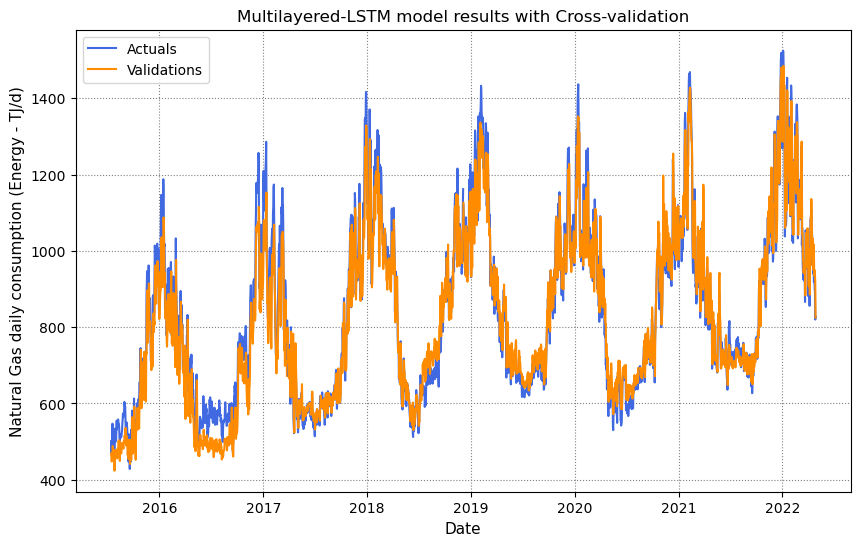


Average Validation Metrics across Folds:
Average MSE: 3504.203
Average MAE: 44.899
Average RMSE: 58.569
Average MAPE: 5.459%
Average MdAPE: 4.764%
Average R-squared: 0.918


In [15]:
# Load the dataset
df = learning_data_df.copy()

# Fill NA/NaN values with 0
df.fillna(0, inplace=True)

# Convert the 'DATE' column to a datetime object and set column as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Define the number of features and time steps
n_features = scaled_df.shape[1]
time_steps = 1  # You can adjust this based on your data and problem

# Create dataset function
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data for LSTM [samples, timesteps, features]
X, y = create_dataset(scaled_df, time_steps)

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(time_steps, n_features)))
model.add(Dropout(0.2))  # Add dropout with rate 0.2
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))  # Add dropout with rate 0.2
model.add(Dense(1))  # You can adjust the number of output units based on your problem
model.compile(optimizer='adam', loss='mean_squared_error')

# Create a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # Calculate MSE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MAPE
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MdAPE (Median Absolute Percentage Error)
    r_squared = r2_score(y_true, y_pred)     # Calculate R-squared
    
    return mse, mae, rmse, mape, mdape, r_squared

plt.figure(figsize=(10, 6))

# Create a function to train and evaluate the model with cross-validation:
def train_and_evaluate_model(X, y, time_steps, n_features, num_folds=4):
    tscv = TimeSeriesSplit(n_splits=num_folds)
    all_metrics = []

    for train_idx, val_idx in tscv.split(X):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Evaluate the model
        y_pred = model.predict(X_val)
        
        # Reshape y_pred and y_val to 2D arrays for inverse_transform
        y_pred_2D = y_pred.reshape(-1, 1)
        y_val_2D = y_val.reshape(-1, 1)
        
        # Inverse transform the predictions and true values
        y_pred_inv = scaler_y.inverse_transform(y_pred_2D)
        y_true_inv = scaler_y.inverse_transform(y_val_2D)
        
        # Flatten y_pred and y_true to match the original shape
        y_pred_flat = y_pred_inv.flatten()
        y_true_flat = y_true_inv.flatten()
        
        # Calculate metrics
        mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(y_true_flat, y_pred_flat)
        all_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

        print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

        # Plot actuals vs. forecasts for this fold
        plt.plot(df.iloc[val_idx].index, y_true_flat, color='royalblue', label='Actuals')
        plt.plot(df.iloc[val_idx].index, y_pred_flat, color='darkorange', label='Validations')

    plt.title('Multilayered-LSTM model results with Cross-validation',fontsize=12)
    plt.xlabel('Date',fontsize=11)
    plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)',fontsize=11)
    
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()
    
    # Calculate the average metrics across folds
    avg_optimized_metrics = np.mean(all_metrics, axis=0)
    print("\nAverage Validation Metrics across Folds:")
    print(f"Average MSE: {avg_optimized_metrics[0]:.3f}")
    print(f"Average MAE: {avg_optimized_metrics[1]:.3f}")
    print(f"Average RMSE: {avg_optimized_metrics[2]:.3f}")
    print(f"Average MAPE: {avg_optimized_metrics[3]:.3f}%")
    print(f"Average MdAPE: {avg_optimized_metrics[4]:.3f}%")
    print(f"Average R-squared: {avg_optimized_metrics[5]:.3f}")

    return all_metrics
    
# Call the function to train and evaluate the model
layered_average_metrics = train_and_evaluate_model(X, y, time_steps, n_features)


### Hyperparameter Tuning (Optimized-LSTM)

#### 2.2.1. Singlelayered LSTM model 

- This code is designed to build and tune a single layer LSTM model using Keras and Keras Tuner. It uses time series cross-validation to evaluate the model’s performance on different folds of the data. The performance metrics are calculated for each fold and the results are plotted. 
- The model with the best hyperparameters is saved for future use. The dropout rate is also tuned to prevent overfitting. The code is modular and each function has a specific role, making it easier to understand and modify. The code is also flexible and can be easily adapted to other tasks by changing the model architecture, hyperparameters, or evaluation metrics. 
- The use of Keras Tuner simplifies the hyperparameter tuning process and makes it easier to find the optimal model configuration. 
- The use of time series cross-validation ensures that the model’s performance is evaluated in a way that is appropriate for time series data.

The LSTM model is built with an LSTM layer, a Dropout layer, and a Dense output layer, with hyperparameters set for tuning. The Keras Tuner’s RandomSearch is used for hyperparameter tuning with the aim to minimize validation mean absolute error. Performance metrics including MSE, MAE, RMSE, MAPE, MdAPE, and R-squared are calculated. Finally, the optimized model is trained and evaluated using cross-validation, with performance metrics calculated for each fold.

The goal of cross-validation is to assess the predictive performance of the machine learning model and to judge how it performs outside the sample to a new data set also known as test data. The motivation to use cross-validation techniques is that when we fit a model, we are fitting it to a training dataset. Without cross-validation, we only have information on how does our model perform to our in-sample data. Ideally, we would like to see how does the model perform when we have a new data in terms of accuracy of its predictions. In science, theories are judged by its predictive accuracies. 

Reloading Tuner from my_dir\tuning\tuner0.json
Search space summary
Default search space size: 10
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, '

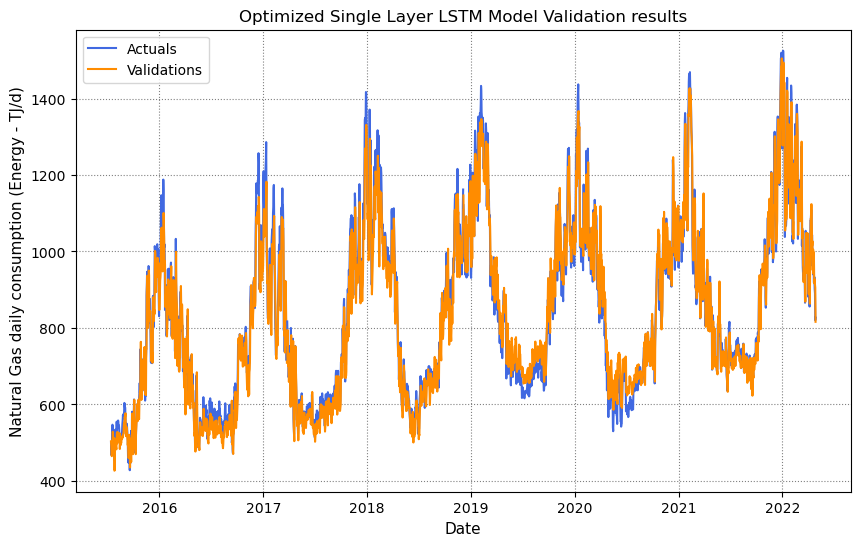


Average Validation Metrics across Folds:
Mean Squared Error: 2870.197
Mean Absolute Error: 40.403
Root Mean Squared Error: 53.558
Mean Absolute Percentage Error: 4.834%
Median Absolute Percentage Error: 3.951%
R-squared: 0.935


In [32]:
# Load the dataset
df = learning_data_df.copy()

# Convert the 'DATE' column to a datetime object and set column as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Define the number of features and time steps
n_features = scaled_df.shape[1]
time_steps = 1

# Create dataset function
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data for LSTM [samples, timesteps, features]
X, y = create_dataset(scaled_df, time_steps)

# Define a function to build the model
def build_model(hp):
    model = Sequential()
    # Add an LSTM layer with hyperparameters to be tuned
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                   activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']), 
                   input_shape=(time_steps, n_features)))
    # Add a Dropout layer with a dropout rate to be tuned
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    # Add a Dense layer for the output
    model.add(Dense(1))
    # Compile the model with an optimizer and loss function to be tuned
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Initialize the tuner for hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective=Objective('val_mean_absolute_error', direction='min'),  # set the objective to minimize mean absolute error
    max_trials=5,  # set the maximum number of trials for tuning
    executions_per_trial=3,  # set the number of executions per trial
    directory='my_dir',  # set the directory where to save the logs
    project_name='tuning'  # set project name
)

# Print a summary of the search space
#tuner.search_space_summary()

# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    # Calculate various performance metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = r2_score(y_true, y_pred)
    
    return mse, mae, rmse, mape, mdape, r_squared

# Initialize a plot for visualizing the results
plt.figure(figsize=(10, 6))

# Define a function to train and evaluate the model with cross-validation
def train_and_evaluate_optimized_model(X, y, time_steps, n_features, num_folds=4):   
    # Initialize the TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=num_folds)
    all_metrics = []

    best_model = None  # Initialize the best model variable

    # Loop over the folds
    for train_idx, val_idx in tscv.split(X):
        # Split the data into training and validation sets
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        # Perform hyperparameter tuning on the model
        tuner.search(X_train, y_train, epochs=50, validation_split=(X_val, y_val))
        
        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Print the best hyperparameters
        print(f"Best hyperparameters: {best_hps.get_config()}")       
        
        # Build the model with the optimal hyperparameters
        best_model = tuner.hypermodel.build(best_hps)

        # Train the model
        best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Evaluate the model
        y_pred = best_model.predict(X_val)
        
        # Reshape y_pred and y_val to 2D arrays for inverse_transform
        y_pred_2D = y_pred.reshape(-1, 1)
        y_val_2D = y_val.reshape(-1, 1)
        
        # Inverse transform the predictions and true values
        y_pred_inv = scaler_y.inverse_transform(y_pred_2D)
        y_true_inv = scaler_y.inverse_transform(y_val_2D)

        # Flatten y_pred and y_true to match the original shape
        y_pred_flat = y_pred_inv.flatten()
        y_true_flat = y_true_inv.flatten()
        
        # Calculate the performance metrics
        mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(y_true_flat, y_pred_flat)
        all_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

        # Print the performance metrics for this fold
        print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

        # Plot actuals vs. forecasts for this fold
        plt.plot(df.iloc[val_idx].index, y_true_flat, color='royalblue', label='Actuals')
        plt.plot(df.iloc[val_idx].index, y_pred_flat, color='darkorange', label='Validations')

    # Set the title for the plot
    plt.title('Optimized Single Layer LSTM Model Validation results', fontsize=12)
    plt.xlabel('Date', fontsize=11)
    plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)
    
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()

    # Calculate and print the average metrics across folds
    avg_hyper_metrics = np.mean(all_metrics, axis=0)   
    print("\nAverage Validation Metrics across Folds:")
    print(f"Mean Squared Error: {avg_hyper_metrics[0]:.3f}")
    print(f"Mean Absolute Error: {avg_hyper_metrics[1]:.3f}")
    print(f"Root Mean Squared Error: {avg_hyper_metrics[2]:.3f}")
    print(f"Mean Absolute Percentage Error: {avg_hyper_metrics[3]:.3f}%")
    print(f"Median Absolute Percentage Error: {avg_hyper_metrics[4]:.3f}%")
    print(f"R-squared: {avg_hyper_metrics[5]:.3f}")

    # Save the best model using joblib
    best_model.save('../models/optimized_singlelayer_lstm_model.h5')

    return all_metrics
    
# Call the function to train and evaluate the model
average_optimized_metrics = train_and_evaluate_optimized_model(X, y, time_steps, n_features)

#### 2.2.2. Multilayered LSTM model 

Reloading Tuner from my_dir\tuning\tuner0.json
Search space summary
Default search space size: 10
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, '

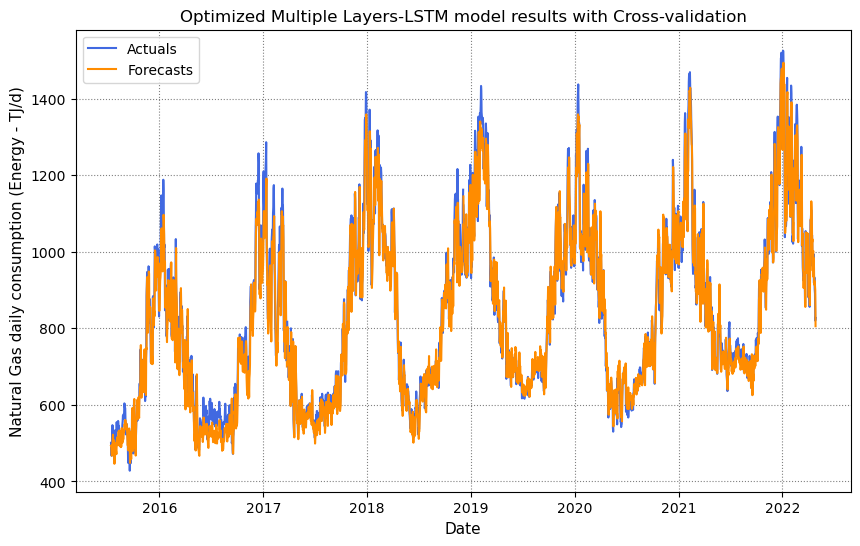


Average Metrics across Folds:
Mean Squared Error: 2664.376%
Mean Absolute Error: 38.411
Root Mean Squared Error: 51.554
Mean Absolute Percentage Error: 4.561%
Median Absolute Percentage Error: 3.698%
R-squared: 0.939


In [30]:
# Load the dataset
df = learning_data_df.copy()

# Convert the 'DATE' column to a datetime object and set column as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Define the number of features and time steps
n_features = scaled_df.shape[1]
time_steps = 1

# Create dataset function
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data for LSTM [samples, timesteps, features]
X, y = create_dataset(scaled_df, time_steps)

def build_model(hp):
    model = Sequential()
    # Add the first LSTM layer with hyperparameters to be tuned
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32), 
                   activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid']), 
                   input_shape=(time_steps, n_features), return_sequences=True))
    # Add a Dropout layer with a dropout rate to be tuned for the first layer
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    # Add the second LSTM layer with hyperparameters to be tuned
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32), 
                   activation=hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])))
    # Add a Dropout layer with a dropout rate to be tuned for the second layer
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    # Add a Dense layer for the output
    model.add(Dense(1))
    # Compile the model with an optimizer and loss function to be tuned
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

tuner = RandomSearch(
    build_model,
    objective=Objective('val_mean_absolute_error', direction='min'),  # set the objective
    max_trials=5,  # set the maximum number of trials
    executions_per_trial=3,  # set the number of executions per trial
    directory='my_dir',  # set the directory where to save the logs
    project_name='tuning'  # set project name
)

tuner.search_space_summary()

# Create a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # Calculate MSE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MAPE
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MdAPE (Median Absolute Percentage Error)
    r_squared = r2_score(y_true, y_pred)     # Calculate R-squared
    
    return mse, mae, rmse, mape, mdape, r_squared

plt.figure(figsize=(10, 6))

# Create a function to train and evaluate the model with cross-validation:
def train_and_evaluate_optimized_model(X, y, time_steps, n_features, num_folds=4):
       
    tscv = TimeSeriesSplit(n_splits=num_folds)
    all_metrics = []

    best_model = None  # Initialize the best model variable
    
    for train_idx, val_idx in tscv.split(X):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        # Perform hyperparameter tuning on the model
        tuner.search(X_train, y_train, epochs=50, validation_split=(X_val, y_val))
        
        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Print the best hyperparameters
        #print(f"Best hyperparameters: {best_hps.get_config()}") 
        
        # Build the model with the optimal hyperparameters
        model = tuner.hypermodel.build(best_hps)

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Evaluate the model
        y_pred = model.predict(X_val)
        
        # Reshape y_pred and y_val to 2D arrays for inverse_transform
        y_pred_2D = y_pred.reshape(-1, 1)
        y_val_2D = y_val.reshape(-1, 1)
        
        # Inverse transform the predictions and true values
        y_pred_inv = scaler_y.inverse_transform(y_pred_2D)
        y_true_inv = scaler_y.inverse_transform(y_val_2D)
        
        # Flatten y_pred and y_true to match the original shape
        y_pred_flat = y_pred_inv.flatten()
        y_true_flat = y_true_inv.flatten()
        
        # Calculate metrics
        mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(y_true_flat, y_pred_flat)
        all_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

        print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

        # Plot actuals vs. forecasts for this fold
        plt.plot(df.iloc[val_idx].index, y_true_flat, color='royalblue', label='Actuals')
        plt.plot(df.iloc[val_idx].index, y_pred_flat, color='darkorange', label='Forecasts')

    plt.title('Optimized Multiple Layers-LSTM model results with Cross-validation', fontsize=12)
    plt.xlabel('Date', fontsize=11)
    plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)
    
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()
    # Calculate the average metrics across folds
    avg_hyp_metrics = np.mean(all_metrics, axis=0)   
    print("\nAverage Metrics across Folds:")
    print(f"Mean Squared Error: {avg_hyp_metrics[0]:.3f}%")
    print(f"Mean Absolute Error: {avg_hyp_metrics[1]:.3f}")
    print(f"Root Mean Squared Error: {avg_hyp_metrics[2]:.3f}")
    print(f"Mean Absolute Percentage Error: {avg_hyp_metrics[3]:.3f}%")
    print(f"Median Absolute Percentage Error: {avg_hyp_metrics[4]:.3f}%")
    print(f"R-squared: {avg_hyp_metrics[5]:.3f}")

    # Save the best model using joblib
    model.save('../models/optimized_multilayered_lstm_model.h5')
    
    return all_metrics
    
# Call the function to train and evaluate the model
average_optimized_metrics_layered = train_and_evaluate_optimized_model(X, y, time_steps, n_features)

### LSTM Model Validation Performance

In [20]:
# Accessing individual metrics for Singlelayer LSTM model with cross-validation 
mse_lstm1_cv = np.mean(average_CV_metrics, axis=0)[0]
mae_lstm1_cv = np.mean(average_CV_metrics, axis=0)[1]
rmse_lstm1_cv = np.mean(average_CV_metrics, axis=0)[2]
mape_lstm1_cv = np.mean(average_CV_metrics, axis=0)[3]
mdape_lstm1_cv = np.mean(average_CV_metrics, axis=0)[4]
r2_lstm1_cv = np.mean(average_CV_metrics, axis=0)[5]

# Accessing individual metrics for Multilayer LSTM model with cross-validation 
mse_lstm2_cv = np.mean(layered_average_metrics, axis=0)[0]
mae_lstm2_cv = np.mean(layered_average_metrics, axis=0)[1]
rmse_lstm2_cv = np.mean(layered_average_metrics, axis=0)[2]
mape_lstm2_cv = np.mean(layered_average_metrics, axis=0)[3]
mdape_lstm2_cv = np.mean(layered_average_metrics, axis=0)[4]
r2_lstm2_cv = np.mean(layered_average_metrics, axis=0)[5]

# Accessing individual metrics for Optimized Singlelayer LSTM model with cross-validation 
mse_lstm1_hy = np.mean(average_optimized_metrics, axis=0)[0]
mae_lstm1_hy = np.mean(average_optimized_metrics, axis=0)[1]
rmse_lstm1_hy = np.mean(average_optimized_metrics, axis=0)[2]
mape_lstm1_hy = np.mean(average_optimized_metrics, axis=0)[3]
mdape_lstm1_hy = np.mean(average_optimized_metrics, axis=0)[4]
r2_lstm1_hy = np.mean(average_optimized_metrics, axis=0)[5]

# Accessing individual metrics for Optimized Multilayer LSTM model with cross-validation 
mse_lstm2_hy = np.mean(average_optimized_metrics_layered, axis=0)[0]
mae_lstm2_hy = np.mean(average_optimized_metrics_layered, axis=0)[1]
rmse_lstm2_hy = np.mean(average_optimized_metrics_layered, axis=0)[2]
mape_lstm2_hy = np.mean(average_optimized_metrics_layered, axis=0)[3]
mdape_lstm2_hy = np.mean(average_optimized_metrics_layered, axis=0)[4]
r2_lstm2_hy = np.mean(average_optimized_metrics_layered, axis=0)[5]

# Define the metrics for the model
metrics_baseline_model = [mse_bm, rmse_bm, mape_bm, mae_bm, mdape_bm, r2_bm]
metrics_lstm1_cv = [mse_lstm1_cv, rmse_lstm1_cv, mape_lstm1_cv, mae_lstm1_cv, mdape_lstm1_cv, r2_lstm1_cv]
metrics_lstm2_cv = [mse_lstm2_cv, rmse_lstm2_cv, mape_lstm2_cv, mae_lstm2_cv, mdape_lstm2_cv, r2_lstm2_cv]
optimized_metrics_lstm1 = [mse_lstm1_hy, rmse_lstm1_hy, mape_lstm1_hy, mae_lstm1_hy, mdape_lstm1_hy, r2_lstm1_hy]
optimized_metrics_lstm2 = [mse_lstm2_hy, rmse_lstm2_hy, mape_lstm2_hy, mae_lstm2_hy, mdape_lstm2_hy, r2_lstm2_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics_lstm = pd.DataFrame({'Baseline Model': metrics_baseline_model, 'Single-layer LSTM with Cross-validation': metrics_lstm1_cv, 
                                'Multi-layer LSTM with Cross-validation': metrics_lstm2_cv, 'Optimized Single-layer LSTM': optimized_metrics_lstm1, 
                                'Optimized Multi-layer LSTM': optimized_metrics_lstm2}, index=labels)

# Transpose the DataFrame
df_metrics_lstm = df_metrics_lstm.transpose()

df_metrics_lstm = df_metrics_lstm.applymap(lambda x: f'{x: .3}')
df_metrics_lstm.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline Model,6.66e+03,81.6,7.33,70.2,7.05,0.854
Single-layer LSTM with Cross-validation,3.03e+03,54.7,4.98,41.4,4.2,0.93
Multi-layer LSTM with Cross-validation,3.5e+03,58.6,5.46,44.9,4.76,0.918
Optimized Single-layer LSTM,2.8e+03,52.9,4.59,38.9,3.71,0.936
Optimized Multi-layer LSTM,3.05e+03,55.0,5.02,41.7,4.26,0.93


Here's a summary and comparison of the different models based on the metrics above:

1. **Baseline Model**: This model has the highest error rates across all metrics (MSE, RMSE, MAPE, MAE, MDAPE) and a relatively lower R-squared value of 0.854, indicating that it has the poorest performance among all models.

2. **Single-layer LSTM with Cross-validation**: This model significanhasia ne, red all error ra93, indicating a better fit to the  than the baseline modeldata.

3. **Multi-layer LSTM with Cross-validation**: This modehigherhigher error rates compared to the single-layer LSTM with cross-validation, and a slightly lower R-squared value918 0.887.

4. **Optimized Single-layer This model performs the best among all models but todels. The R-squared value is  higher y lower than the non-optimized single-layer LSTM3.t 0.919.

5. **Optimized Multi-layeThis model has the third highest error rates and a R-squared value of 0.93, indicating that the optimization did improve the performance of the multi-layer LSTM.ayer LSTM.

In summary, the **Single-layer LSTM with Cross-validation** appears to be the best model among these, as it has the lowest error rates and the highest R-squared value. However, the baseline model is a Linear Regression model, which is a simple yet powerful statistical model used for predicting a quantitative response. It assumes a linear relationship between the input features and the output.

On the other hand, the rest of the models are LSTM (Long Short-Term Memory) models, which are a type of Recurrent Neural Network (RNN) that can learn and remember over long sequences of data. They are particularly useful for time series forecasting, among other applications.

In the performance summary, it’s evident that the LSTM models (both single-layer and multi-layer, with and without optimization) outperform the Linear Regression model across all metrics. This could be due to the LSTM’s ability to capture temporal dependencies in the data, which a Linear Regression mdel might miata.ounterparts.

## LSTM model Testing Performance

18/18 [==============================] - 1s 3ms/step

Prediction Singlelayered LSTM Performance Metrics for the Testing Dataset:
Test Mean Squared Error: 1902.626
Test Mean Absolute Error: 32.092
Test Root Mean Squared Error: 43.619
Test Mean Absolute Percentage Error: 3.515%
Test Median Absolute Percentage Error: 2.780%
Test R-squared: 0.955

Prediction Multilayered LSTM Performance Metrics for the Testing Dataset:
Test Mean Squared Error: 1855.091
Test Mean Absolute Error: 31.360
Test Root Mean Squared Error: 43.071
Test Mean Absolute Percentage Error: 3.415%
Test Median Absolute Percentage Error: 2.515%
Test R-squared: 0.956


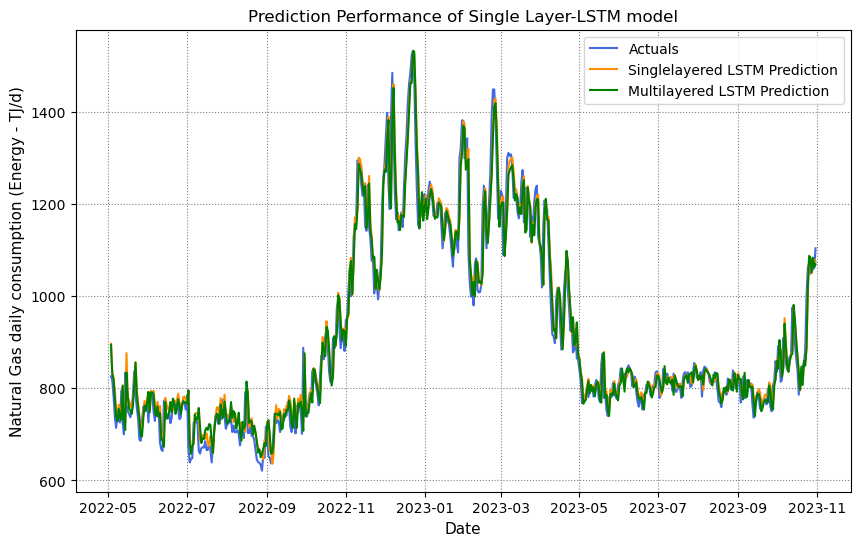

In [34]:
# Load the model
loaded_singlelayered_model = keras.models.load_model('../models/singlelayer_lstm_cv_model.h5')
loaded_multilayered_model = keras.models.load_model('../models/optimized_multilayered_lstm_model.h5')

# Load the dataset
testing_set_df = testing_data_df.copy()

# Convert the 'DATE' column to a datetime object and set column as the index
testing_set_df['DATE'] = pd.to_datetime(testing_set_df['DATE'])
testing_set_df.set_index('DATE', inplace=True)
testing_set_df.sort_index(inplace=True)

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(testing_set_df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(testing_set_df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Define the number of features and time steps
n_features = scaled_df.shape[1]
time_steps = 1

# Create dataset function
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # Calculate MSE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MAPE
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100    # Calculate MdAPE (Median Absolute Percentage Error)
    r_squared = r2_score(y_true, y_pred)     # Calculate R-squared
    
    return mse, mae, rmse, mape, mdape, r_squared


# Reshape the data for LSTM [samples, timesteps, features]
X_test, y_test = create_dataset(scaled_df, time_steps)

# Evaluate the final model on the test dataset
y_test_pred = loaded_singlelayered_model.predict(X_test)
y_test_pred2 = loaded_multilayered_model.predict(X_test)

# Reshape y_test_pred and y_test to 2D arrays for inverse_transform
y_test_pred_2D = y_test_pred.reshape(-1, 1)
y_test_pred2_2D = y_test_pred2.reshape(-1, 1)
y_test_2D = y_test.reshape(-1, 1)
        
# Inverse transform the predictions and true values
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred_2D)
y_test_pred2_inv = scaler_y.inverse_transform(y_test_pred2_2D)
y_test_true_inv = scaler_y.inverse_transform(y_test_2D)

# Flatten y_test_pred and y_test_true to match the original shape
y_test_pred_flat = y_test_pred_inv.flatten()
y_test_pred2_flat = y_test_pred2_inv.flatten()
y_test_true_flat = y_test_true_inv.flatten()

# Calculate performance metrics for the test set
test_mse, test_mae, test_rmse, test_mape, test_mdape, test_r_squared = calculate_metrics(y_test_true_flat, y_test_pred_flat)
test2_mse, test2_mae, test2_rmse, test2_mape, test2_mdape, test2_r_squared = calculate_metrics(y_test_true_flat, y_test_pred2_flat)


# Print optimized Singlelayered LSTM prediction performance metrics
print("\nPrediction Singlelayered LSTM Performance Metrics for the Testing Dataset:")
print(f'Test Mean Squared Error: {test_mse:.3f}')
print(f'Test Mean Absolute Error: {test_mae:.3f}')
print(f'Test Root Mean Squared Error: {test_rmse:.3f}')
print(f'Test Mean Absolute Percentage Error: {test_mape:.3f}%')
print(f'Test Median Absolute Percentage Error: {test_mdape:.3f}%')
print(f'Test R-squared: {test_r_squared:.3f}')

# Print optimized Multilayered LSTM prediction performance metrics
print("\nPrediction Multilayered LSTM Performance Metrics for the Testing Dataset:")
print(f'Test Mean Squared Error: {test2_mse:.3f}')
print(f'Test Mean Absolute Error: {test2_mae:.3f}')
print(f'Test Root Mean Squared Error: {test2_rmse:.3f}')
print(f'Test Mean Absolute Percentage Error: {test2_mape:.3f}%')
print(f'Test Median Absolute Percentage Error: {test2_mdape:.3f}%')
print(f'Test R-squared: {test2_r_squared:.3f}')

# Datetime array corresponding to the dates in the test dataset
test_dates = testing_set_df.index[-len(y_test_true_flat):]

# Plot actuals vs. forecasts for this fold
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_true_flat, color='royalblue', label='Actuals')
plt.plot(test_dates, y_test_pred_flat, color='darkorange', label='Singlelayered LSTM Prediction')
plt.plot(test_dates, y_test_pred2_flat, color='green', label='Multilayered LSTM Prediction')
plt.title('Prediction Performance of Single Layer-LSTM model', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

lstm_results_df = pd.DataFrame()
lstm_results_df['DATE'] = testing_set_df.index[-len(y_test_true_flat):]
lstm_results_df['NG_DEMAND'] = y_test_true_flat
lstm_results_df['Predicted_NG_DEMAND'] = y_test_pred2_flat

In [35]:
lstm_results_df.reset_index(drop=True, inplace=True)
lstm_results_df.to_csv('../data/lstm_prediction.csv', index=False)
lstm_results_df.head()

,DATE,NG_DEMAND,Predicted_NG_DEMAND
0,2022-05-03,826.0,894.273499
1,2022-05-04,818.0,830.237427
2,2022-05-05,782.0,820.023682
3,2022-05-06,737.0,780.223877
4,2022-05-07,714.0,738.198547


In [36]:
# Define the metrics for the predicted model
lstm_prediction_metrics = [test2_mse, test2_mae, test2_rmse, test2_mape, test2_mdape, test2_r_squared]

# Define the labels for the metrics
labels = ['MSE', 'MAE', 'RMSE', 'MAPE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_lstm_pred = pd.DataFrame({'LSTM Model Prediction': lstm_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_lstm_pred = df_lstm_pred.transpose()

# Save the DataFrame to a CSV file
df_lstm_pred.to_csv('../data/lstm_predictions_metrics.csv', index=False)
df_lstm_pred.head(10)

,MSE,MAE,RMSE,MAPE,MDAPE,R-squared
LSTM Model Prediction,1855.090745,31.359789,43.070764,3.414569,2.515046,0.956021


# Conclusion
In conclusion, while both models perform well, the multi-layer LSTM model performs slightly better than the single-layer LSTM model on the testing dataset across all metrics. However, the differences are relatively small, suggesting that both models are comparable in their performance. The choice between a single-layer and multi-layer LSTM would depend on the specific requirements of your task, such as computational resources and model complexity. It’s always a good practice to try out different models and choose the one that best suits your specific needs. Remember, while the multi-layer LSTM model has shown better performance in this case, it doesn’t mean it will always be the superior choice. The effectiveness of a model can vary based on the problem at hand. 